In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
pd.set_option('display.max_colwidth', 100)

messages = pd.read_csv('Data/spam.csv', encoding='latin-1')
messages = messages.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'], axis=1)
messages.columns = ['label', 'text']
labels = np.where(messages['label']=='spam', 1, 0)

X_train, X_test, y_train, y_test = train_test_split(messages['text'], labels, test_size=0.2)

In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [4]:
# Initialize and fit the Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [5]:
# Use that Tokenizer to transform the text messages in the training and test sets
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [6]:
# What do these sequences look like?
X_test_seq[0]

[100, 740, 113, 10, 171, 35, 255]

In [9]:
# Pad the sequences so each sequence is the same length
X_train_seq_padded = pad_sequences(X_train_seq, 50)
X_test_seq_padded = pad_sequences(X_test_seq, 50)

In [10]:
X_train_seq_padded[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    8,   14,   13, 1262, 1440,   20,
        519,    9,    5, 3846,   27, 1678])

### Build Model

In [11]:
import keras.backend as K
from keras.layers import Dense, Embedding, LSTM
from keras.models import Sequential

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

In [15]:
# Construct a RNN Model
model = Sequential()

model.add(Embedding(len(tokenizer.index_word)+1, 32))
model.add(LSTM(32, dropout=0, recurrent_dropout=0))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          255040    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 264,449
Trainable params: 264,449
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Compile the Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision_m, recall_m])

In [17]:
# Fit the RNN Model
history = model.fit(X_train_seq_padded, y_train, batch_size=32, epochs=10, validation_data=(X_test_seq_padded, y_test))

Epoch 1/10
140/140 [==============================] - 3s 22ms/step - loss: 0.2619 - accuracy: 0.9168 - precision_m: 0.5210 - recall_m: 0.4269 - val_loss: 0.0623 - val_accuracy: 0.9821 - val_precision_m: 0.9959 - val_recall_m: 0.8625
Epoch 2/10
140/140 [==============================] - 3s 18ms/step - loss: 0.0321 - accuracy: 0.9912 - precision_m: 0.9600 - recall_m: 0.9355 - val_loss: 0.0471 - val_accuracy: 0.9874 - val_precision_m: 1.0000 - val_recall_m: 0.8985
Epoch 3/10
140/140 [==============================] - 2s 17ms/step - loss: 0.0124 - accuracy: 0.9966 - precision_m: 0.9896 - recall_m: 0.9755 - val_loss: 0.0511 - val_accuracy: 0.9857 - val_precision_m: 1.0000 - val_recall_m: 0.8912
Epoch 4/10
140/140 [==============================] - 2s 18ms/step - loss: 0.0076 - accuracy: 0.9982 - precision_m: 0.9686 - recall_m: 0.9638 - val_loss: 0.0691 - val_accuracy: 0.9821 - val_precision_m: 1.0000 - val_recall_m: 0.8714
Epoch 5/10
140/140 [==============================] - 2s 17ms/step -

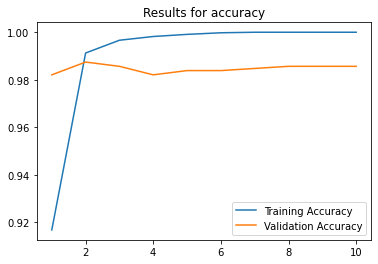

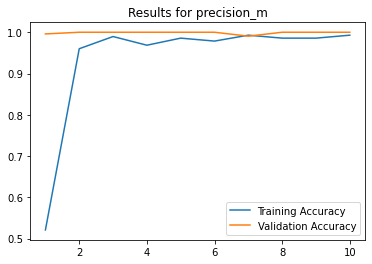

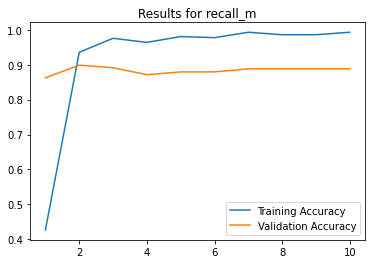

In [18]:
# Plot the evaluation metrics by each epoch for the model to see if we are over or underfitting
import matplotlib.pyplot as plt

for i in ['accuracy', 'precision_m', 'recall_m']:
    acc = history.history[i]
    val_acc = history.history['val_{}'.format(i)]
    epochs = range(1, len(acc) + 1)

    plt.figure()
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Results for {}'.format(i))
    plt.legend()
    plt.show()